##**<font color="green">Fintech and Digital Innovation in Finance**
###**<font color="green">Course project part 1 | Text embeddings and Technical Analysis on S&P 500 data**
###**<font color="green">Section A**
###**Renzo Zagni A01795457**</font>



# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [4]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [5]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf

In [6]:
#
# Additional libraries used
import time
import os
import pickle
import numpy as np
from IPython.display import clear_output
from datetime import datetime
import seaborn as sns

In [7]:
#
# Let's connect to G Drive to save some objects in case we need to reuse them
from google.colab import drive
drive.mount('/content/drive')
working_dir = '/content/drive/MyDrive/MNA/Fintech'

if not os.path.isdir(working_dir):
    print(f"Directory {working_dir} doesn\'t exists. Creating...")
    os.makedirs(working_dir)
os.chdir(working_dir)
print(f"Working directory: {working_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/MNA/Fintech


## Get the list of stocks in the S&P 500

In [8]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [9]:
ticker_list = df_tickers['Symbol'].tolist()

In [10]:
#
# Addressing a known issue with dots in the ticker name
ticker_list = [ticker.replace('.', '-') for ticker in ticker_list]

In [12]:
print(f"Number of Tickers Downloaded: {len(ticker_list)}")

Number of Tickers Downloaded 503


## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [11]:
def get_news(ticker_list, news_dict=None, max_attempts=10, delay=0.5):
    """
    Get financial news for a list of stock tickers using yfinance.

    Parameters
    ----------
    ticker_list : list of str
        List of stock ticker symbols to fetch news for.
    news_dict : dict, optional
        Existing dictionary of previously fetched news.
    max_attempts : int, default=10
        Maximum retry attempts for failed tickers.
    delay : float, default=0.5
        Delay in seconds between API calls.

    Returns
    -------
    news_dict : dict
        Dictionary mapping tickers to lists of news articles.
    remaining : list of str
        Tickers that still failed after all retry attempts.
    """
    if news_dict is None:
        news_dict = {}

    remaining = ticker_list.copy()
    attempt = 1
    empty_news_tickers = []

    while remaining and attempt <= max_attempts:
        failed = []
        total = len(remaining)

        for idx, ticker in enumerate(remaining, 1):
            clear_output(wait=True)
            print("Downloading news from Yahoo Finance...")
            print(f"[Attempt {attempt}] Processing: {ticker}")
            print(f"Processed: {idx} of {total} | Errors: {len(failed)}")

            try:
                stock = yf.Ticker(ticker)
                news = stock.news
                if news is None:
                    raise ValueError("yfinance returned None for news")

                news_dict[ticker] = news

                if isinstance(news, list) and len(news) == 0:
                    empty_news_tickers.append(ticker)

            except Exception as e:
                failed.append(ticker)

            time.sleep(delay)

        print(f"\nAttempt {attempt} complete. {len(failed)} tickers failed.\n")

        if not failed:
            break

        remaining = failed
        attempt += 1

    return news_dict, failed, empty_news_tickers


In [13]:
#
# In case we already ran this notebook and want to reuse the dictionary created
# during previous executions
news_dict_pickle = 'news_dict.pkl'
news_dict = {}

if not os.path.isfile(news_dict_pickle):


    news_dict, still_failed, empty_news = get_news(ticker_list)

    if still_failed:
        print(f"Tickers failed after retries: {still_failed}")
    else:
        print("All tickers processed successfully!")

    print(f"Tickers with no news (empty): {len(empty_news)}")

else:
    print("News already downloaded. Loading news from local file")
    with open(news_dict_pickle, 'rb') as f:
        news_dict = pickle.load(f)

[Attempt 1] Processing: ZTS
Processed: 503 of 503 | Errors: 0

Attempt 1 complete. 0 tickers failed.

All tickers processed successfully!
Tickers with no news (empty): 0


In [14]:
#
# Let's save the news_dict for reusability a
news_dict_pickle = 'news_dict.pkl'
if not os.path.isfile(news_dict_pickle):
    with open(news_dict_pickle, 'wb') as f:
        pickle.dump(news_dict, f)

In [15]:
#
# Let's explore the contents of news_dict for on ticker: BF-B
news_dict['BF-B']

[{'id': '74e47a72-9a1c-374d-8ee4-49a45e9564a1',
  'content': {'id': '74e47a72-9a1c-374d-8ee4-49a45e9564a1',
   'contentType': 'STORY',
   'title': 'Purchasing Power Of Black And Latino Consumers Too Great For Companies To Ignore DEI',
   'description': '',
   'summary': 'Black and Latino Americans, who make up more than 30% of the U.S. population, have a combined spending power of $6 trillion, according to the National Urban League.',
   'pubDate': '2025-07-28T15:00:00Z',
   'displayTime': '2025-07-28T15:00:00Z',
   'isHosted': True,
   'bypassModal': False,
   'previewUrl': None,
   'thumbnail': {'originalUrl': 'https://media.zenfs.com/en/black_enterprise_497/051a524c3866cae1eeefe31e7fd750b8',
    'originalWidth': 600,
    'originalHeight': 456,
    'caption': '"Protestor holding a sign that says \'Equality in Diversity\'"',
    'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/OqSd6P2f2XoeFv1XLMsTRg--~B/aD00NTY7dz02MDA7YXBwaWQ9eXRhY2h5b24-/https://media.zenfs.com/en/black_en

### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [17]:
# Including provider attribute as specified in the rubric
# Create a structured DataFrame containing: TICKER, TITLE, SUMMARY, PUBLICATION_DATE, URL, PROVIDER.

rows = []

for ticker, articles in news_dict.items():
    if not articles:
        continue

    for article in articles:
        content = article.get('content') or {}

        title = content.get('title', '').strip()
        summary = content.get('summary', '').strip()

        url = (
            (content.get('clickThroughUrl') or {}).get('url') or
            content.get('previewUrl') or
            (content.get('canonicalUrl') or {}).get('url') or
            ''
        ).strip()

        pub_date_str = content.get('pubDate', '').strip()
        try:
            pub_date = datetime.strptime(pub_date_str, "%Y-%m-%dT%H:%M:%SZ")
            formatted_date = pub_date.strftime('%d-%b-%y')
        except Exception:
            formatted_date = ''

        provider = (content.get('provider') or {}).get('displayName', '').strip()

        # Skipping articles with missing information
        if not any([title, summary, formatted_date, url, provider]):
            continue

        rows.append({
            'TICKER': ticker,
            'TITLE': title,
            'SUMMARY': summary,
            'PUBLICATION_DATE': formatted_date,
            'URL': url,
            'PROVIDER': provider
        })

df_news = pd.DataFrame(rows)

In [18]:
# Review the first 10 articles
df_news.head(10)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,PROVIDER
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,24-Jul-25,https://finance.yahoo.com/news/3m-company-mmm-...,Insider Monkey
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",21-Jul-25,https://finance.yahoo.com/news/zacks-industry-...,Zacks
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,21-Jul-25,https://finance.yahoo.com/news/stock-market-ne...,Zacks
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,19-Jul-25,https://finance.yahoo.com/news/3m-co-mmm-q2-20...,GuruFocus.com
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,19-Jul-25,https://finance.yahoo.com/news/mmm-q1-deep-div...,StockStory
5,MMM,Dow Falls as Trump Reportedly Seeks Higher EU ...,The Dow Jones Industrial Average fell Friday f...,18-Jul-25,https://finance.yahoo.com/news/dow-falls-trump...,MT Newswires
6,MMM,3M Gives Investors a ‘Beat and Raise.’ The Sto...,3M traded higher initially after reporting be...,18-Jul-25,https://finance.yahoo.com/m/b7e536e2-6640-3d38...,Barrons.com
7,MMM,Equities Fall Intraday as Trump Reportedly Pus...,US benchmark equity indexes fell intraday amid...,18-Jul-25,https://finance.yahoo.com/news/equities-fall-i...,MT Newswires
8,MMM,US Equity Indexes Slip in Choppy Trading After...,US equity indexes slipped in choppy midday tra...,18-Jul-25,https://finance.yahoo.com/news/us-equity-index...,MT Newswires
9,MMM,"3M (MMM) Stock Trades Down, Here Is Why",Shares of industrial conglomerate 3M (NYSE:MMM...,18-Jul-25,https://finance.yahoo.com/news/3m-mmm-stock-tr...,StockStory


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [19]:
# Loading the pre-trained embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Adding column EMBEDDED_TEXT using ONLY the TITLE of the news.
# This is redundant but we are following the requirements...
df_news['EMBEDDED_TEXT'] = (
    df_news['TITLE'].fillna('')
)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
# Generate embeddings
embeddings = model.encode(df_news['EMBEDDED_TEXT'].tolist(), show_progress_bar=True)

# Store embeddings in the DataFrame
df_news['EMBEDDINGS'] = embeddings.tolist()

Batches:   0%|          | 0/158 [00:00<?, ?it/s]

## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [21]:
# Let's keep only the first news entry per ticker
df_news = df_news.drop_duplicates(subset='TICKER', keep='first').reset_index(drop=True)

# Let's verify the results
print(f"Number of unique tickers: {df_news['TICKER'].nunique()}")
print(f"Total rows: {len(df_news)}")

Number of unique tickers: 503
Total rows: 503


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [22]:
embedding_matrix = np.vstack(df_news['EMBEDDINGS'].values)

cluster_results = {}

for k in range(1, 7):
    print(f"\nClustering with k={k}")
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding_matrix)

    df_news[f'CLUSTER_{k}'] = cluster_labels

    if k > 1:
        score = silhouette_score(embedding_matrix, cluster_labels)
        print(f"Silhouette Score (k={k}): {score:.4f}")
        cluster_results[k] = {
            'labels': cluster_labels,
            'score': score,
            'model': kmeans
        }
    else:
        print("Silhouette score not defined for k=1")
        cluster_results[k] = {
            'labels': cluster_labels,
            'score': None,
            'model': kmeans
        }



Clustering with k=1
Silhouette score not defined for k=1

Clustering with k=2
Silhouette Score (k=2): 0.0493

Clustering with k=3
Silhouette Score (k=3): 0.0519

Clustering with k=4
Silhouette Score (k=4): 0.0325

Clustering with k=5
Silhouette Score (k=5): 0.0405

Clustering with k=6
Silhouette Score (k=6): 0.0438


#### Plot silhouette scores

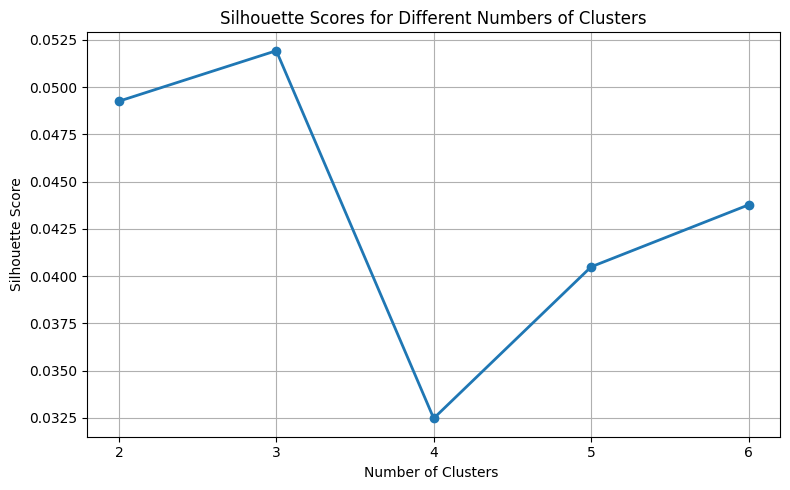

In [23]:
k_values = []
scores = []

for k, result in cluster_results.items():
    if result['score'] is not None:
        k_values.append(k)
        scores.append(result['score'])


plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o', linestyle='-', linewidth=2)
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters ")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Identify the Best k

In [24]:
best_k = k_values[np.argmax(scores)]
best_score = max(scores)

print(f" The best number of clusters (k): {best_k} with silhouette score: {best_score:.4f}")


 The best number of clusters (k): 3 with silhouette score: 0.0519


#### Cluster the embeddings using 3 clusters (k=3)

In [25]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_news['CLUSTER'] = kmeans.fit_predict(embedding_matrix)

# Check cluster sizes
print(df_news['CLUSTER'].value_counts())


CLUSTER
2    193
1    168
0    142
Name: count, dtype: int64


### Visualize the 2 first PCA Components of your embeddings

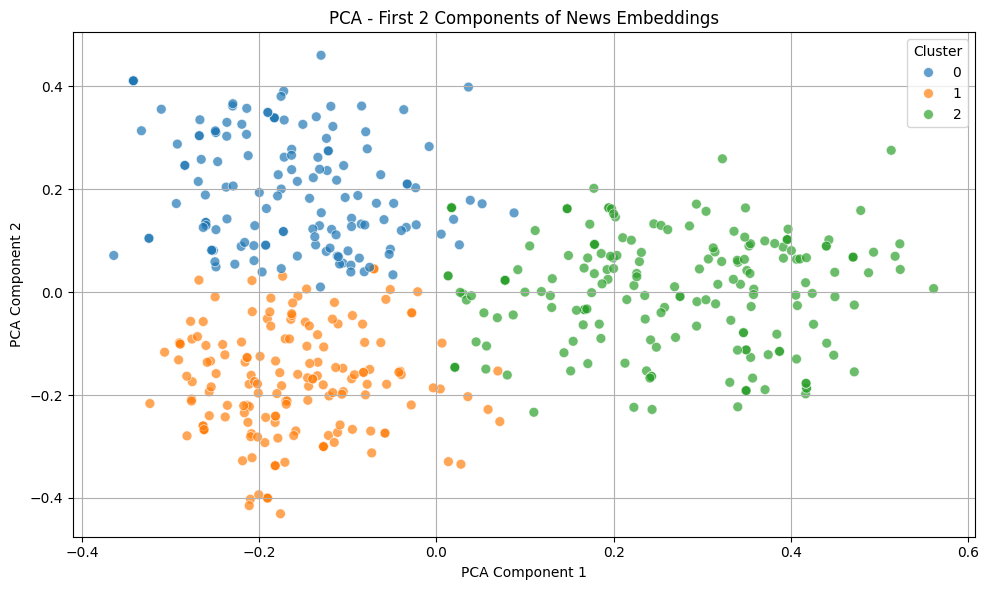

In [26]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

df_news['PCA1'] = reduced_embeddings[:, 0]
df_news['PCA2'] = reduced_embeddings[:, 1]


plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='CLUSTER',
    palette='tab10',
    data=df_news,
    s=50,
    alpha=0.7
)

plt.title("PCA - First 2 Components of News Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [27]:
# Max lenght of TITLE across all tickers
max_title_length = df_news['TITLE'].str.len().max()
ticker_width = 8
title_width = max_title_length + 5


for cluster_id in sorted(df_news['CLUSTER'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_df = df_news[df_news['CLUSTER'] == cluster_id]
    print(f"Number of articles: {len(cluster_df)}\n")

    print(f"{'TICKER'.ljust(ticker_width)} | {'TITLE'.ljust(title_width)}")
    print("-" * (ticker_width + title_width + 3))

    for _, row in cluster_df[['TICKER', 'TITLE']].iterrows():
        print(f"{row['TICKER'].ljust(ticker_width)} | {row['TITLE'].ljust(title_width)}")


--- Cluster 0 ---
Number of articles: 142

TICKER   | TITLE                                                                                                                                     
-----------------------------------------------------------------------------------------------------------------------------------------------------
MMM      | 3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer                                                           
ABT      | Revvity trims 2025 profit forecast as China policy changes hit diagnostics demand                                                         
ABBV     | HS market forecast to reach $7.8bn across 7MM by 2034                                                                                     
ADBE     | Tech, Media & Telecom Roundup: Market Talk                                                                                                
AFL      | Can ACGL's New Health Suite Boost Growth and 

# <font color="green">Cluster Analisys:</font>

<font color="green">**Cluster 0: Macro & Market Events**
This cluster covers macroeconomic shifts, regulatory changes, and strategic company responses across industries. It includes executive commentary, geopolitical developments, and consumer behavior trends—especially around healthcare and trade. The tone ranges from cautious to optimistic, often featuring thought-leader insights and bull case views. Articles help investors connect broader forces like tariffs, AI, and energy shifts to company and market performance..</font>

<font color="green">**Cluster 1: Investment Outlook & Stock Picks**
Cluster 1  focuses on broad economic trends and their effect on markets. Topics include Fed policy, jobs data, tariffs, and overall earnings sentiment. Many articles share similar headlines across tickers, reflecting general market outlooks tied to key macro events. It’s most useful for investors and strategists tracking how economic cycles and policy shifts influence equities.</font>

<font color="green">**Cluster 2: Earnings-Focused Reports**
Cluster 2 focuses on quarterly earnings updates, with structured articles covering expected results, earnings beats or misses, and analyst reactions. The tone is neutral and data-driven, providing key metrics and guidance. It serves as a practical tool for investors making short-term decisions based on company performance during earnings season..</font>





## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

<font color="green">The embedding model selected can make a big difference in how well clustering works and how easy it is to rationalize the results. Smaller models like MiniLM are fast and efficient, which is great if we're working with a lot of data or limited resources but they might miss some of the deeper meaning in the text, leading to clusters that are broader or less accurate. On the other hand, larger transformer models usually capture more nuance and context, which can help create clearer, more meaningful groupings. That said, they also require more computing power (memory, CPU and GPU) and time. At the end , it comes down to finding the right balance between performance and practicality for the specific use case.</font>

---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

<font color="green"> Using only the title for embeddings gives us a quick overview of what the news is about. Titles are usually short and meant to grab attention, so they usually capture the main topic well. But because they’re so brief, they often miss important context or details that could change how we understand the story—especially in something as complex as financial news.</font>

<font color="green">On the other hand, using only the summary gives a fuller picture. Summaries usually include key facts, context, and sometimes sentiment, which makes the embeddings more meaningful. They can also include extra information that might not be relevant. Combining both the title and summary strikes a good balance between the clarity of the title and the depth of the summary. This combined approach usually results in more useful embeddings, particularly for cases requiring to understand how news might affect stock prices.</font>


<font color="green">To test this empirically, I would start by creating three sets of embeddings: one using only the titles, one using only the summaries, and one using both combined. Then, I would:</font>

<font color="green"> 1. Calculate the best K for each cluster. This will give me an idea of the level of refinement per cluster obtained by each of the sets. I would use metrics like the silhouette score or the elbow method to determine which number of clusters offers the best separation and cohesion within the data.</font>

<font color="green"> 2. Analyze each group of clusters using three different K values (3, 4, and 6) across all embedding sets. This would allow me to compare how the structure and separation of clusters change depending on the input text used. I’d look at how consistently meaningful or interpretable the clusters are, whether certain stock tickers or industries tend to group together, and if combining title and summary leads to tighter or more relevant clusters compared to using either one alone.</font>


<font color="green">This process would help  understand which input captures more useful information and how that information influences the way news articles are grouped, potentially revealing patterns relevant to market behavior or news themes.</font>

---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

<font color="green">Using t-SNE or UMAP instead of PCA is preferable when we want to visualize complex, non-linear relationships in high-dimensional data like text embeddings. These methods are  useful for preserving local structure, meaning they keep similar data points close together in 2D space, which helps detect natural clusters that PCA might miss. PCA is fast and good for capturing global variance, it assumes linearity and can overlook important patterns. On the other hand, t-SNE and UMAP provide more intuitive visualizations for exploring groupings or similarities, making them better choices for tasks like understanding topic clusters or sentiment groupings in news embeddings.</font>

---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

<font color="green">One challenge I faced was interpreting the meaning of each cluster, especially when the articles within a cluster didn’t share clearly obvious themes or keywords. Since embeddings capture complex semantic patterns, the clusters sometimes grouped articles that seemed unrelated at first glance. To address this, I would generate top keywords or use topic modeling (like LDA) within each cluster to better understand the dominant themes.

Another challenge was deciding the right number of clusters (K). Choosing too few led to overly broad groupings, while too many caused overfitting with small, noisy clusters. To improve this, I’d rely more on evaluation metrics like the silhouette score and visual inspection using UMAP or t-SNE plots to help guide the choice of K and validate the meaningfulness of each group.</font>


---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

<font color="green">Yes, I did observe some outliers in the 2D visualization, where a few data points appeared far from the main clusters. These could represent unusual or unrelared news articles that didn't fit well with the main theme in the dataset. In a production pipeline, I would identify outliers by calculating the distance of each embedding to its assigned cluster center after KMeans clustering. Then, for each cluster, I’d apply a box and whisker plot to those distances. Any articles with distances beyond 1.5 times the interquartile range (IQR) would be flagged as outliers. This method is lightweight, interpretable, and easy to automate, making it well-suited for a production environment. Depending on the use case, these flagged articles could be logged, reviewed, or handled separately—for example, triggering alerts for potentially market-moving or unusual news events.</font>

---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

<font color="green"> I did assign a label/theme to each cluster as part of the cluster analysis above. These are: Cluster 0: Earnings-Focused Reports, Cluster 1: Strategic Developments and Cluster 2: Investment Outlook. </font>

<font color="green">I have medium level of confidence on my assignments since these based on my own interpretation bound to my ability to identify meaningful financial patterns given I'm not an expert in the area.  </font>

<font color="green">To validate the cluster themes more systematically, I could start by generating word clouds for each cluster to quickly see which words appear most often. This would help highlight the main topics or keywords in each group. I could also use topic modeling tools like LDA or BERTopic to automatically identify common themes based on the text. Another helpful step would be to look at how often certain company names or sectors show up in each cluster. To be more confident, I’d also compare the clusters to known news categories or have an financial analyst manually review a few articles from each group to check if the assigned themes make sense.</font>

---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

<font color="green">Incorporating news sentiment could significantly influence both the clustering  and how we interpret them. Sentiment adds an emotional or directional layer that can be either positive, negative, or neutral and which could cause articles with similar content but different tones to be grouped separately. For example, earnings reports with positive sentiment might cluster apart from those with negative sentiment, even if they’re about the same companies.</font>

<font color="green">In a financial context, this would make the clusters more actionable. Analysts could identify not just what topics are trending, but also how the market feels about them. Including sentiment would help refine cluster insights and support more targeted strategies, such as assessing market risk, investor mood, or forecasting potential stock movements.</font>


---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

<font color="green">K-means clustering has some key limitations with news embeddings—it assumes clusters are spherical and similar in size, struggles with complex or uneven data shapes, and requires you to set the number of clusters (K) in advance. It also uses Euclidean distance, which may not reflect true semantic similarity. Alternatives like DBSCAN or HDBSCAN work better when clusters are irregular or unknown in number, and they can detect outliers too. Hierarchical clustering is another option that shows how clusters relate and doesn’t require K. These methods are often better for messy, real-world text data like financial news.</font>

<font color="green"> Reference: https://medium.com/biased-algorithms/unsupervised-learning-for-document-clustering-38753be457b3</font>

---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

<font color="green">I would begin by aligning each news article with the corresponding stock’s historical price data using the publication date and ticker. Key metrics such as daily or weekly price changes , for example 1 day or 7 days return.  These price movements will serve as target variables, allowing  to measure how stocks react after certain types of news. By associating each article with its semantic cluster (e.g., earnings-focused, strategic, investment outlook), I  would them analyze average returns, volatility, or win/loss ratios across clusters to identify whether certain themes systematically lead to stronger price reactions.

Further enrichment can include adding sentiment scores and using the original text embeddings or PCA-reduced versions as model features. You can then use statistical tests or train predictive models --logistic regression or XGBoost-- to evaluate whether news characteristics, cluster themes, or sentiment can reliably predict future stock performance. </font>

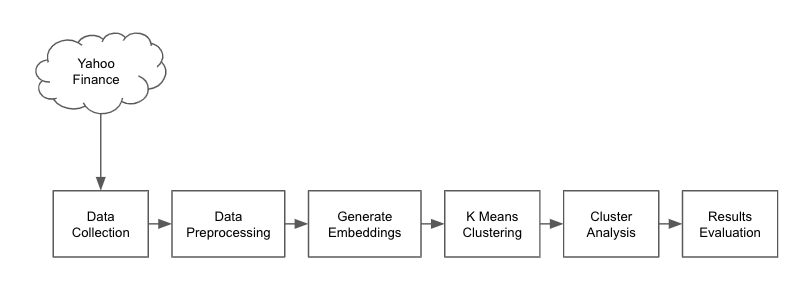


---

#### 10️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

<font color="green">Even when clustering results appear strong like clearly grouping news articles into categories such as earnings reports, product launches, or industry updates; it doesn’t necessarily mean that those clusters will help improve predictions of stock price movements. This disconnect can happen because clustering is based on text similarity, not financial impact. Just because two articles are about similar topics doesn’t mean the market will react to them in the same way. For instance, an earnings report could be positive for one company and negative for another, or it might already be priced into the stock, resulting in no movement at all.

Another possible reason is that the clusters may not capture key factors like sentiment or surprise, which are often more important in determining stock reactions. If a cluster mixes both positive and negative news, the signal becomes diluted and harder to use for prediction. Plus, stock price movements are influenced by many external variables beyond just news content—like macroeconomic events, trading volume, or market sentiment. So even though the clustering provides structure and organization to the news data, it might not align closely enough with what actually drives short-term price changes.</font>

